In [24]:
import sys
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
from pypalettes import load_cmap
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask

project_root = Path().resolve().parent 
sys.path.append(str(project_root))

from src.config import TRAIN_ANNOTATIONS_JSON, VAL_ANNOTATIONS_JSON, FIGURES_DIR
from src.dataset import load_category_mappings, create_segmentation_mask


In [25]:
def load_annotations(ann_file):
    with open(ann_file, "r") as f:
        dataset = json.load(f)

    coco = COCO(ann_file)
    category_mappings = load_category_mappings(ann_file)
    image_data = []

    for img in dataset["images"]:
        img_id = img["id"]
        img_pixels = img["height"] * img["width"]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        mask = create_segmentation_mask(
            coco, img_id, img["height"], img["width"], category_mappings
        )
        total_foreground_pixels = np.count_nonzero(mask)
        if total_foreground_pixels <= 0:
            print(f"NEG or ZERO MASK: {img_id}")

        for ann in anns:
            cat_id = ann["category_id"]
            cat_name = coco.cats[cat_id]["name"]
            fg_pixels = ann.get("area", 0)

            image_data.append(
                {
                    "image_id": img_id,
                    "image_label": img["file_name"],
                    "category_id": cat_id,
                    "category_name": cat_name,
                    "category_pixels": fg_pixels,
                    "foreground_pixels": total_foreground_pixels,
                    "image_pixels": img_pixels,
                    "fg_area_ratio": fg_pixels / img_pixels if img_pixels > 0 else 0,
                    "total_area_ratio": total_foreground_pixels / img_pixels
                    if img_pixels > 0
                    else 0,
                }
            )

    return pd.DataFrame(image_data)

train_df = load_annotations(TRAIN_ANNOTATIONS_JSON)
val_df = load_annotations(VAL_ANNOTATIONS_JSON)

dataset_df = pd.concat([train_df, val_df], ignore_index=True)

dataset_df.head()

KeyboardInterrupt: 

## Counting the number of images per label

In [ ]:
main_item_names = [
    "shirt, blouse",
    "top, t-shirt, sweatshirt",
    "sweater",
    "cardigan",
    "jacket",
    "vest",
    "pants",
    "shorts",
    "skirt",
    "coat",
    "dress",
    "jumpsuit",
    "cape",
    "glasses",
    "hat",
    "headband, head covering, hair accessory",
    "tie",
    "glove",
    "watch",
    "belt",
    "leg warmer",
    "tights, stockings",
    "sock",
    "shoe",
    "bag, wallet",
    "scarf",
    "umbrella",
]

count_df = (
    dataset_df.groupby(["category_id", "category_name"])["image_id"]
    .apply(list)
    .reset_index(name="occurrence")
)

count_df["label_count"] = count_df["occurrence"].apply(len)
count_df["image_count"] = count_df["occurrence"].apply(lambda x: len(set(x)))

count_df = count_df[count_df["category_name"].isin(main_item_names)]

count_df.head()

,category_id,category_name,occurrence,label_count,image_count
0,0,"shirt, blouse","[17264, 17672, 9459, 16375, 9661, 16113, 20165...",6263,6217
1,1,"top, t-shirt, sweatshirt","[12446, 17107, 9459, 9446, 13028, 16265, 19980...",17025,16639
2,2,sweater,"[12069, 19711, 17338, 12970, 10830, 10723, 169...",1515,1506
3,3,cardigan,"[18278, 14772, 17513, 12748, 15584, 13227, 166...",1119,1113
4,4,jacket,"[17672, 9459, 9446, 13028, 9661, 15671, 10431,...",8016,7921


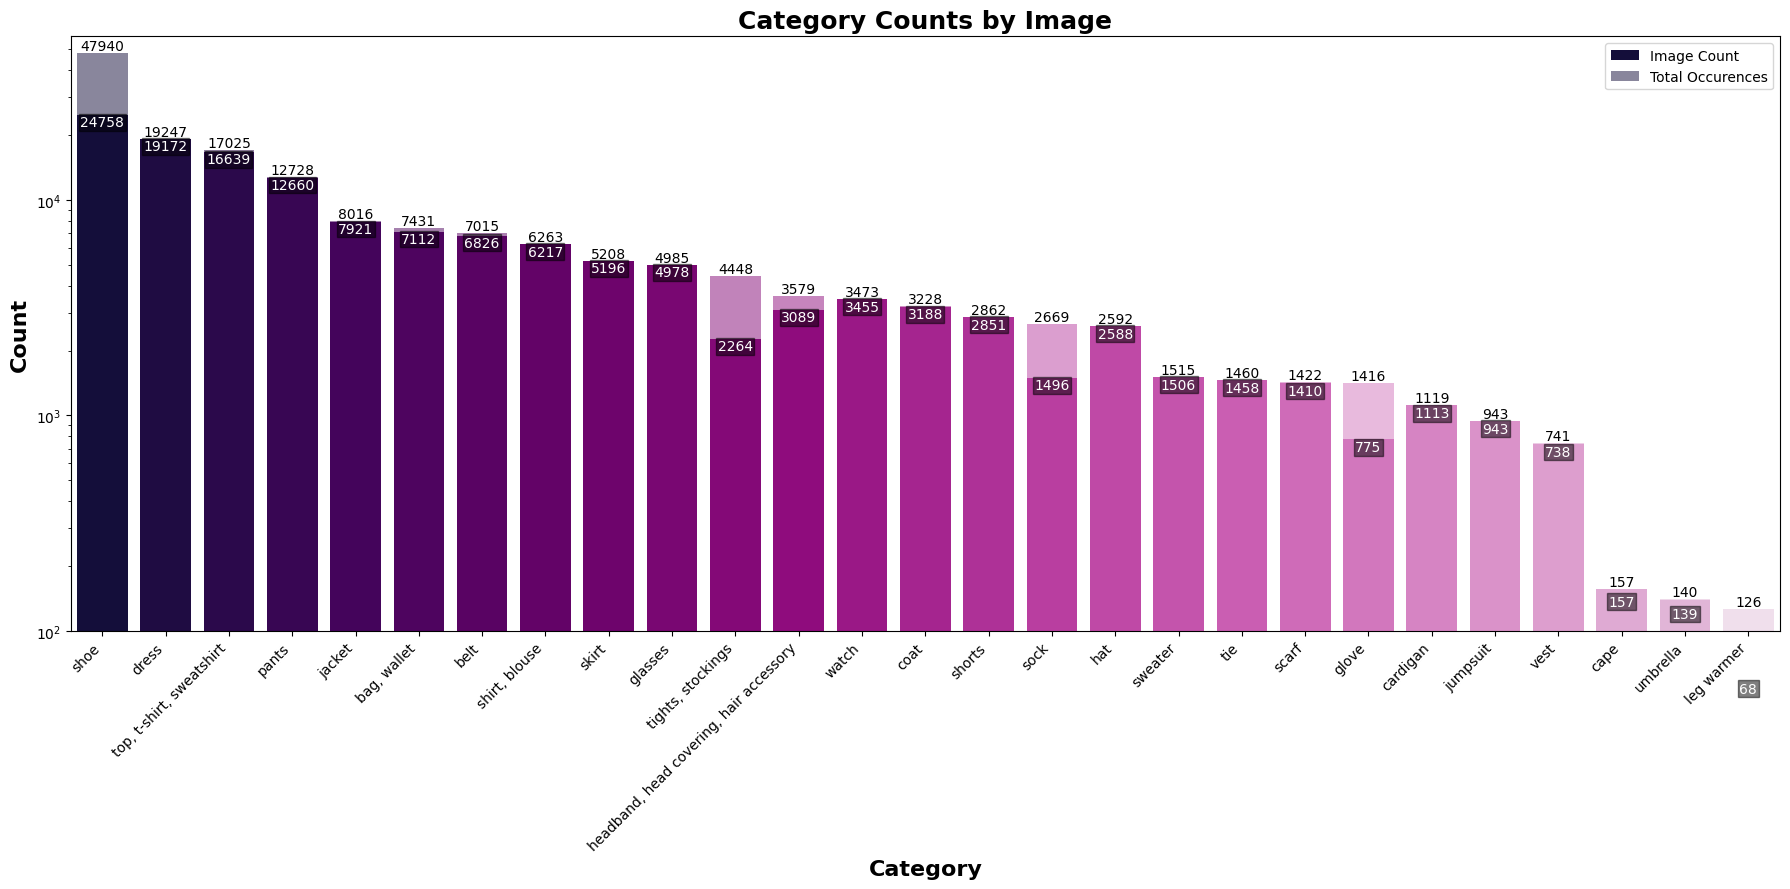

In [32]:
cmap = load_cmap("Flash", cmap_type="continuous", reverse=True)

num_categories = len(count_df)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

sorted_stats = count_df.sort_values("label_count", ascending=False)

plt.figure(figsize=(18, 9))

max_label_count = sorted_stats["label_count"].max()
max_image_count = sorted_stats["image_count"].max()
max_count = max(max_label_count, max_image_count)

plt.ylim(100, max_count * 1.2)

bars1 = plt.bar(
    range(len(sorted_stats)),
    sorted_stats["image_count"],
    color=colors,
    label="Image Count",
)

bars2 = plt.bar(
    range(len(sorted_stats)),
    sorted_stats["label_count"],
    alpha=0.5,
    color=colors,
    label="Total Occurences",
)

plt.xticks(
    range(len(sorted_stats)), sorted_stats["category_name"], rotation=45, ha="right"
)

plt.xlabel("Category", fontsize=16, fontweight="bold")
plt.ylabel("Count", fontsize=16, fontweight="bold")
plt.title("Category Counts by Image", fontsize=18, fontweight="bold")

plt.yscale("log")
plt.xlim(-0.5, len(sorted_stats) - 0.5)

for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height - 10,
        f"{int(height)}",
        ha="center",
        va="top",
        color="white",
        bbox=dict(facecolor="black", alpha=0.5, pad=1),
    )

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom')
    
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_counts_by_image.png")
plt.show()


### Observations and Hypothesis

The Fashionpedia dataset reveals that certain clothing items are significantly more common than others. Among the most frequently occurring labels, "shoe" appears in 24,758 images, followed by "dress" in 19,172 images and "top, t-shirt, sweatshirt" in 16,639 images. In contrast, other labels such as "cape," "umbrella," and "leg warmer" are far less prevalent.

Given this distribution, we hypothesize that clothing segmentation will perform better on the more common categories, as the model is likely to have more training data for these items. Additionally, we examined the total occurrences of each label in comparison to the number of images they appear in, which allowed us to identify items that frequently appear multiple times within a single image. This pattern is particularly evident for labels such as "shoe," "tights, stockings," "sock," "glove," and "leg warmer," as these typically come in pairs. Moreover, accessories tend to appear multiple times per image, which is reasonable given that outfits often include more than one accessory.

Based on these observations, we believe that for labels that occur multiple times within a single image, the clothing segmentation model may perform differently. This could be due to the challenge of accurately identifying and distinguishing multiple instances of the same item within an image.

## Mean and Variance for the Pixel Ratio per Category

In [ ]:
ratio_df = (
    dataset_df.groupby(["category_id", "category_name"])
    .agg(
        area_ratio_mean=("total_area_ratio", "mean"),
        area_ratio_median=("total_area_ratio", "median"),
        area_ratio_stdev=("total_area_ratio", "std"),
        foreground_area_ratio_mean=("fg_area_ratio", "mean"),
        foreground_area_ratio_median=("fg_area_ratio", "median"),
        foreground_area_ratio_stdev=("fg_area_ratio", "std"),
    )
    .reset_index()
)

ratio_df = ratio_df[ratio_df["category_name"].isin(main_item_names)]

ratio_df.head()

,category_id,category_name,area_ratio_mean,area_ratio_median,area_ratio_stdev,foreground_area_ratio_mean,foreground_area_ratio_median,foreground_area_ratio_stdev
0,0,"shirt, blouse",0.231496,0.190352,0.136098,0.093120,0.035904,0.140768
1,1,"top, t-shirt, sweatshirt",0.210955,0.171301,0.141356,0.106995,0.044971,0.149426
2,2,sweater,0.301068,0.267885,0.174348,0.217322,0.128102,0.207131
3,3,cardigan,0.258307,0.198593,0.175112,0.164625,0.074916,0.198394
4,4,jacket,0.221237,0.181508,0.129053,0.133398,0.083535,0.132275


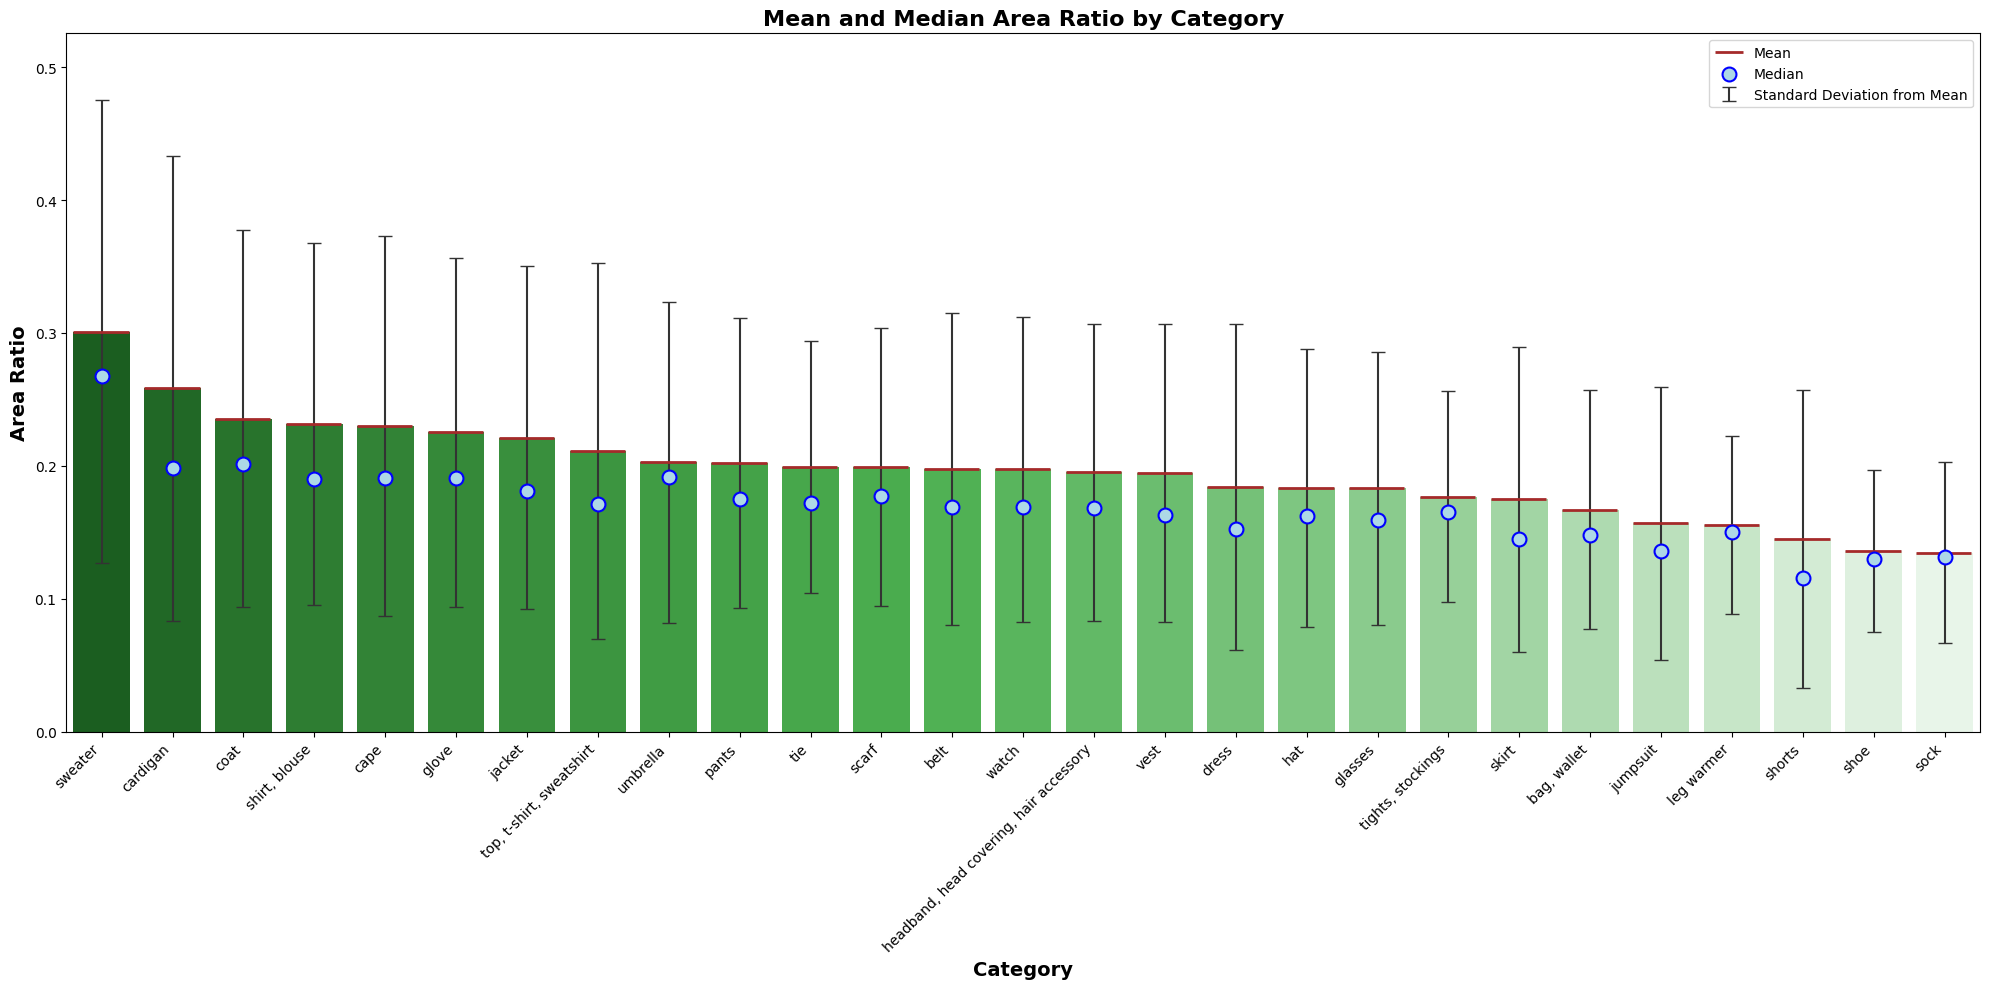

In [ ]:
sorted_stats = ratio_df.sort_values("area_ratio_mean", ascending=False)

cmap = load_cmap("green_material", cmap_type="continuous", reverse=True)

num_categories = len(sorted_stats)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

plt.figure(figsize=(20, 10))

bar_width = 0.8  
x_positions = np.arange(len(sorted_stats))

plt.bar(x_positions, sorted_stats["area_ratio_mean"], color=colors, width=bar_width)

plt.errorbar(
    x_positions,
    sorted_stats["area_ratio_mean"],
    yerr=sorted_stats["area_ratio_stdev"],
    ecolor="#333333",
    capsize=5,
    fmt="none",
    label="Standard Deviation from Mean",
)

plt.hlines(
    y=sorted_stats["area_ratio_mean"],
    xmin=x_positions - 0.4,
    xmax=x_positions + 0.38,
    colors="brown",
    linewidth=2,
    label="Mean",
    zorder=3,
)

plt.xticks(x_positions, sorted_stats["category_name"], rotation=45, ha="right")

plt.xlim(-0.5, len(sorted_stats) - 0.5) 

plt.xlabel("Category", fontsize=14, fontweight="bold")
plt.ylabel("Area Ratio", fontsize=14, fontweight="bold")
plt.title("Mean and Median Area Ratio by Category", fontsize=16, fontweight="bold")

plt.scatter(
    x_positions,
    sorted_stats["area_ratio_median"],
    marker="o",
    color="lightblue",
    edgecolor="blue",
    linewidth=1.5,
    s=100,
    zorder=4,
    label="Median",
)

upper_limit = (
    sorted_stats["area_ratio_mean"] + sorted_stats["area_ratio_stdev"]
).max() + 0.05
plt.ylim(0, upper_limit)

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_area_ratio.png")
plt.show()

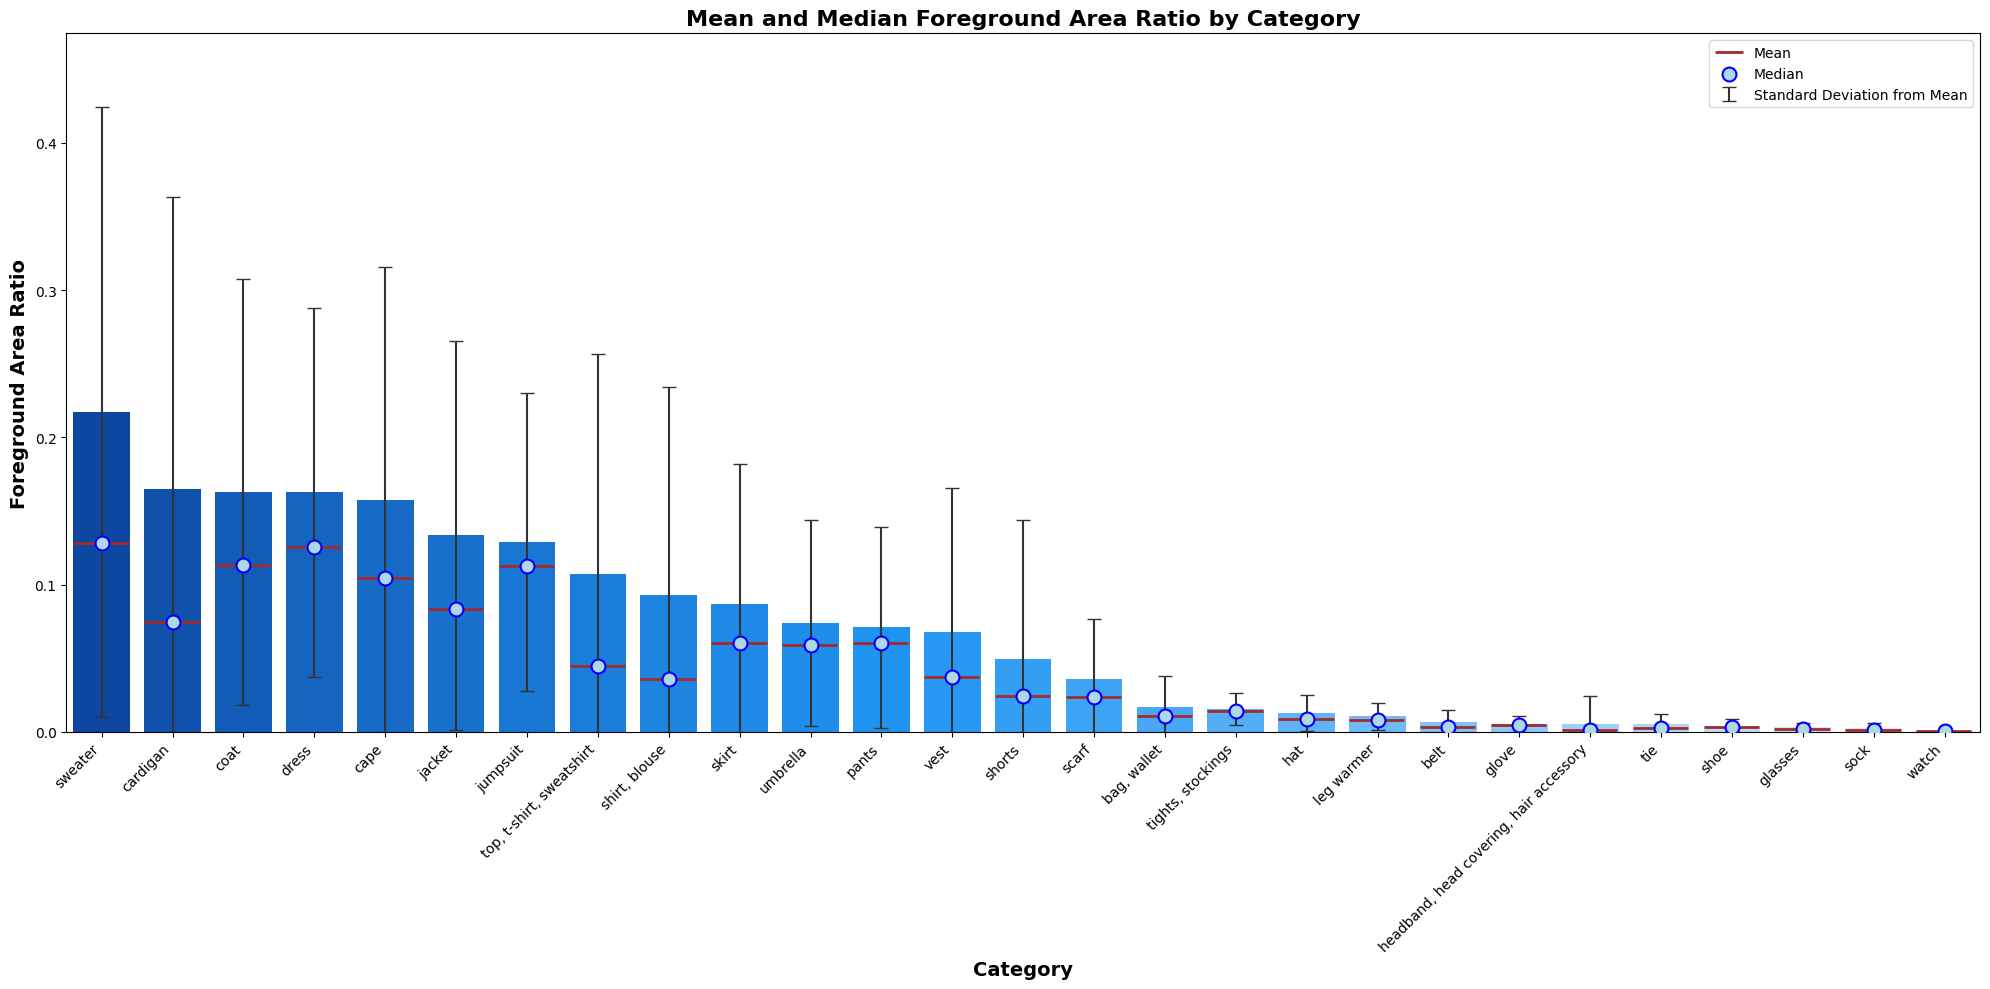

In [ ]:
sorted_stats = ratio_df.sort_values(
    "foreground_area_ratio_mean", ascending=False
)

cmap = load_cmap("blue_material", cmap_type="continuous", reverse=True)

num_categories = len(sorted_stats)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

plt.figure(figsize=(20, 10))

bar_width = 0.8
x_positions = np.arange(len(sorted_stats))

plt.bar(x_positions, sorted_stats["foreground_area_ratio_mean"], color=colors, width=bar_width)

plt.errorbar(
    x_positions,
    sorted_stats["foreground_area_ratio_mean"],
    yerr=sorted_stats["foreground_area_ratio_stdev"],
    ecolor="#333333",
    capsize=5,
    fmt="none",
    label="Standard Deviation from Mean",
)

plt.hlines(
    y=sorted_stats["foreground_area_ratio_median"],
    xmin=x_positions - 0.4,
    xmax=x_positions + 0.38,
    colors="brown",
    linewidth=2,
    label="Mean",
    zorder=3,
)

plt.xticks(x_positions, sorted_stats["category_name"], rotation=45, ha="right")

plt.xlim(-0.5, len(sorted_stats) - 0.5)

plt.xlabel("Category", fontsize=14, fontweight="bold")
plt.ylabel("Foreground Area Ratio", fontsize=14, fontweight="bold")
plt.title("Mean and Median Foreground Area Ratio by Category", fontsize=16, fontweight="bold")

plt.scatter(
    x_positions,
    sorted_stats["foreground_area_ratio_median"],
    marker="o",
    color="lightblue",
    edgecolor="blue",
    linewidth=1.5,
    s=100,
    zorder=4,
    label="Median",
)

upper_limit = (
    sorted_stats["foreground_area_ratio_mean"]
    + sorted_stats["foreground_area_ratio_stdev"]
).max() + 0.05
plt.ylim(0, upper_limit)

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_foreground_area_ratio.png")
plt.show()